# TwoTC for Twilite and Image-Derived Input Functions

## Setup

In [1]:
# system functions that are always useful to have
import time, sys, os
from pprint import pprint

try:
    import numpy as np
    print("numpy is available")  # numpy is available; Jupyter linter has an issue with numpy
except ImportError:
    print("numpy is not available")
# import numpy as np 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


numpy is available


In [2]:
from PETUtilities import PETUtilities
from IOImplementations import BaseIO
from RBCPartition import RBCPartition
from InputFuncData import InputFuncData
from TwoTCContext import TwoTCContext

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# everything is decay corrected

kerndir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "kernels")
kern = os.path.join(kerndir, "kernel_hct=46.8.nii.gz")

fdgdir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "ses-20210421155709", "pet")
pet = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames_timeAppend-165-ParcSchaeffer-reshape-to-schaeffer-schaeffer.nii.gz")

# no deconv., decay corrected, no recovery coefficient
idif_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif.nii.gz")
# deconv., decay corrected, no recovery coefficient
idif_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif-BoxcarIO-ideal.nii.gz")
idif = InputFuncData.nii_hstack(idif_deconv, idif_embed, t_crossover=300, output_format="fqfn")

# no deconv., decaying, measurements corrected to draw-times
twil_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-embed.nii.gz")
# deconv., decaying, measurements corrected to draw-times, duration ~ 470 sec
twil_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-RadialArteryIO-ideal.nii.gz")
twil = InputFuncData.nii_hstack(twil_deconv, twil_embed, t_crossover=300, output_format="fqfn")
twil = InputFuncData.decay_correct(twil, output_format="fqfn")

codir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "ses-20210421144815", "pet")
v1_idif = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-idif_martinv1.nii.gz")
v1_twil = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-twilite_martinv1.nii.gz")

parc_index = 25  # caudate ~ 26 (Matlab); thalamus ~ 6, 25 (Matlab)

RBCPartition t_crossover: 35


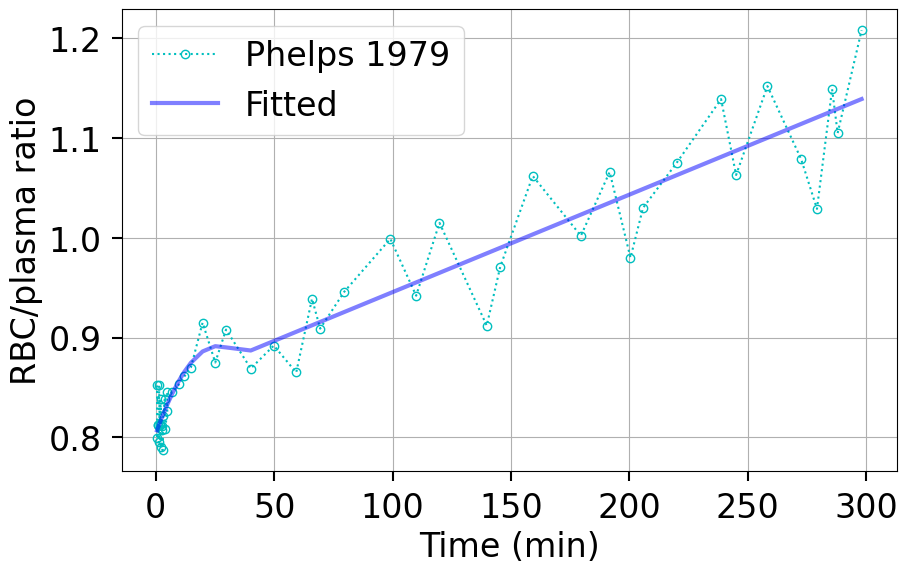

In [4]:
rbcp = RBCPartition(hct=46.8)
print(f"RBCPartition t_crossover: {rbcp.t_crossover}")
rbcp.plot()

## Inspect TwoTCContext twil

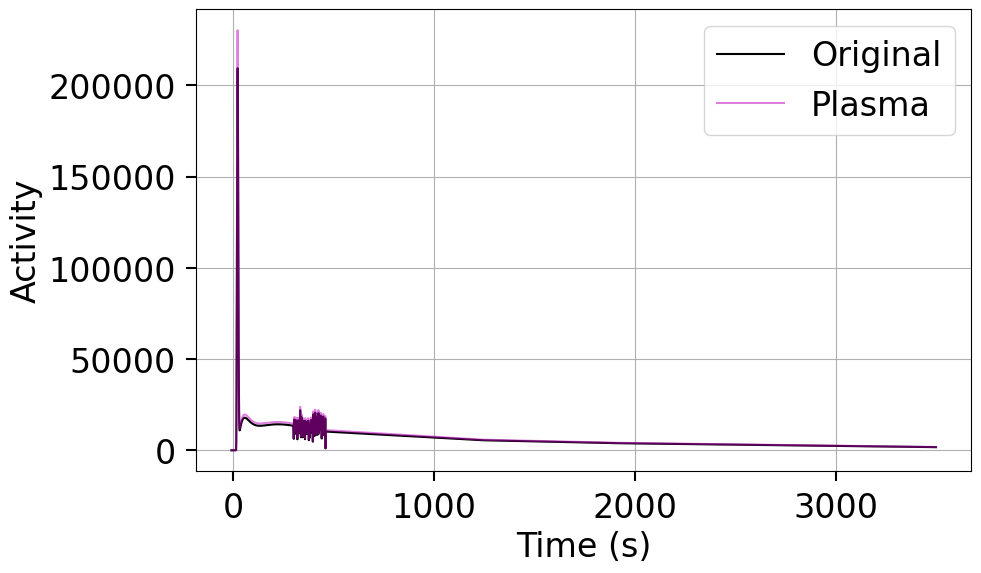

(474,)
'AUC: 22796288.208033822'


In [5]:
twil0 = BaseIO().nii_load(twil)
twil1 = rbcp.nii_wb2plasma(twil, output_format="niid")
twilp = rbcp.nii_wb2plasma(twil, output_format="fqfn")
plt.figure(figsize=(10,6))
plt.plot(twil0["timesMid"], twil0["img"], 'k-', label='Original')
plt.plot(twil1["timesMid"], twil1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

pprint(twil1["img"].shape)
auc = np.trapezoid(twil1["img"], twil1["timesMid"])
pprint(f"AUC: {auc}")

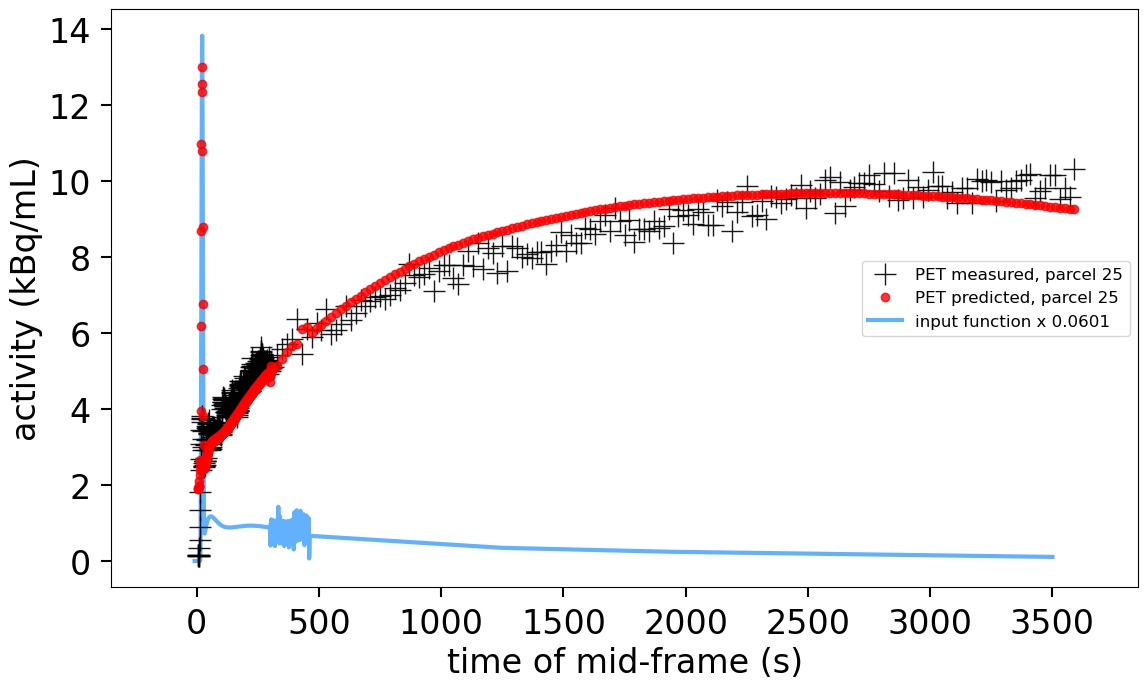

In [17]:
data_dict_twil = {
    "kernel_fqfn": kern,
    "input_func_fqfn": twilp,
    "tissue_fqfn": pet,
    "v1_fqfn": v1_twil,
    "delta_time": 10,
    "nlive": 100,
    "tag": "playground_TwoTC_twil"
}
truth_twotc_twil = [    
    7.85069218e+01, 1.57258831e-03, 7.04297733e+00, 2.68215357e-01,
       1.53364241e+01, 5.00917497e-03, 8.04790998e-02
]
twotc_twil = TwoTCContext(data_dict_twil)
twotc_twil.plotting.truths_plot(truths=truth_twotc_twil, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [7]:
res_twil = twotc_twil.solver.run_nested(print_progress=True, parc_index=parc_index)

9140it [02:29, 35.17it/s, batch: 10 | bound: 48 | nc: 50 | ncall: 556289 | eff(%):  1.643 | loglstar:   -inf < 171.924 < 514.913 | logz: 480.834 +/-  0.277 | stop:  2.514]                   /Users/jjlee/anaconda3/envs/dynesty12/lib/python3.12/site-packages/dynesty/sampling.py:420: UserWarning: The slice sample interval was expanded more than 1000 times
  warnings.warn('The slice sample interval was expanded more '
/Users/jjlee/anaconda3/envs/dynesty12/lib/python3.12/site-packages/dynesty/sampling.py:685: UserWarning: Enabling doubling strategy of slice sampling from Neal(2003)
  warnings.warn('Enabling doubling strategy of slice '
20255it [06:19, 53.42it/s, batch: 21 | bound: 17 | nc: 1 | ncall: 1455883 | eff(%):  1.383 | loglstar: 510.544 < 515.976 < 514.554 | logz: 480.827 +/-  0.193 | stop:  0.970]     


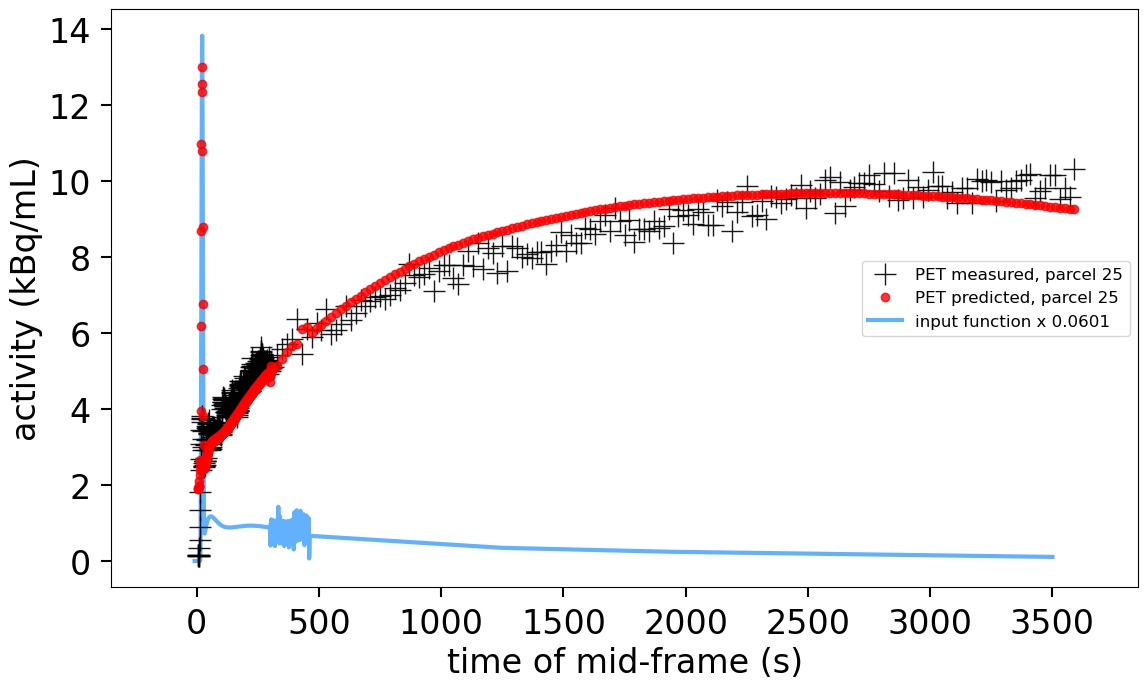

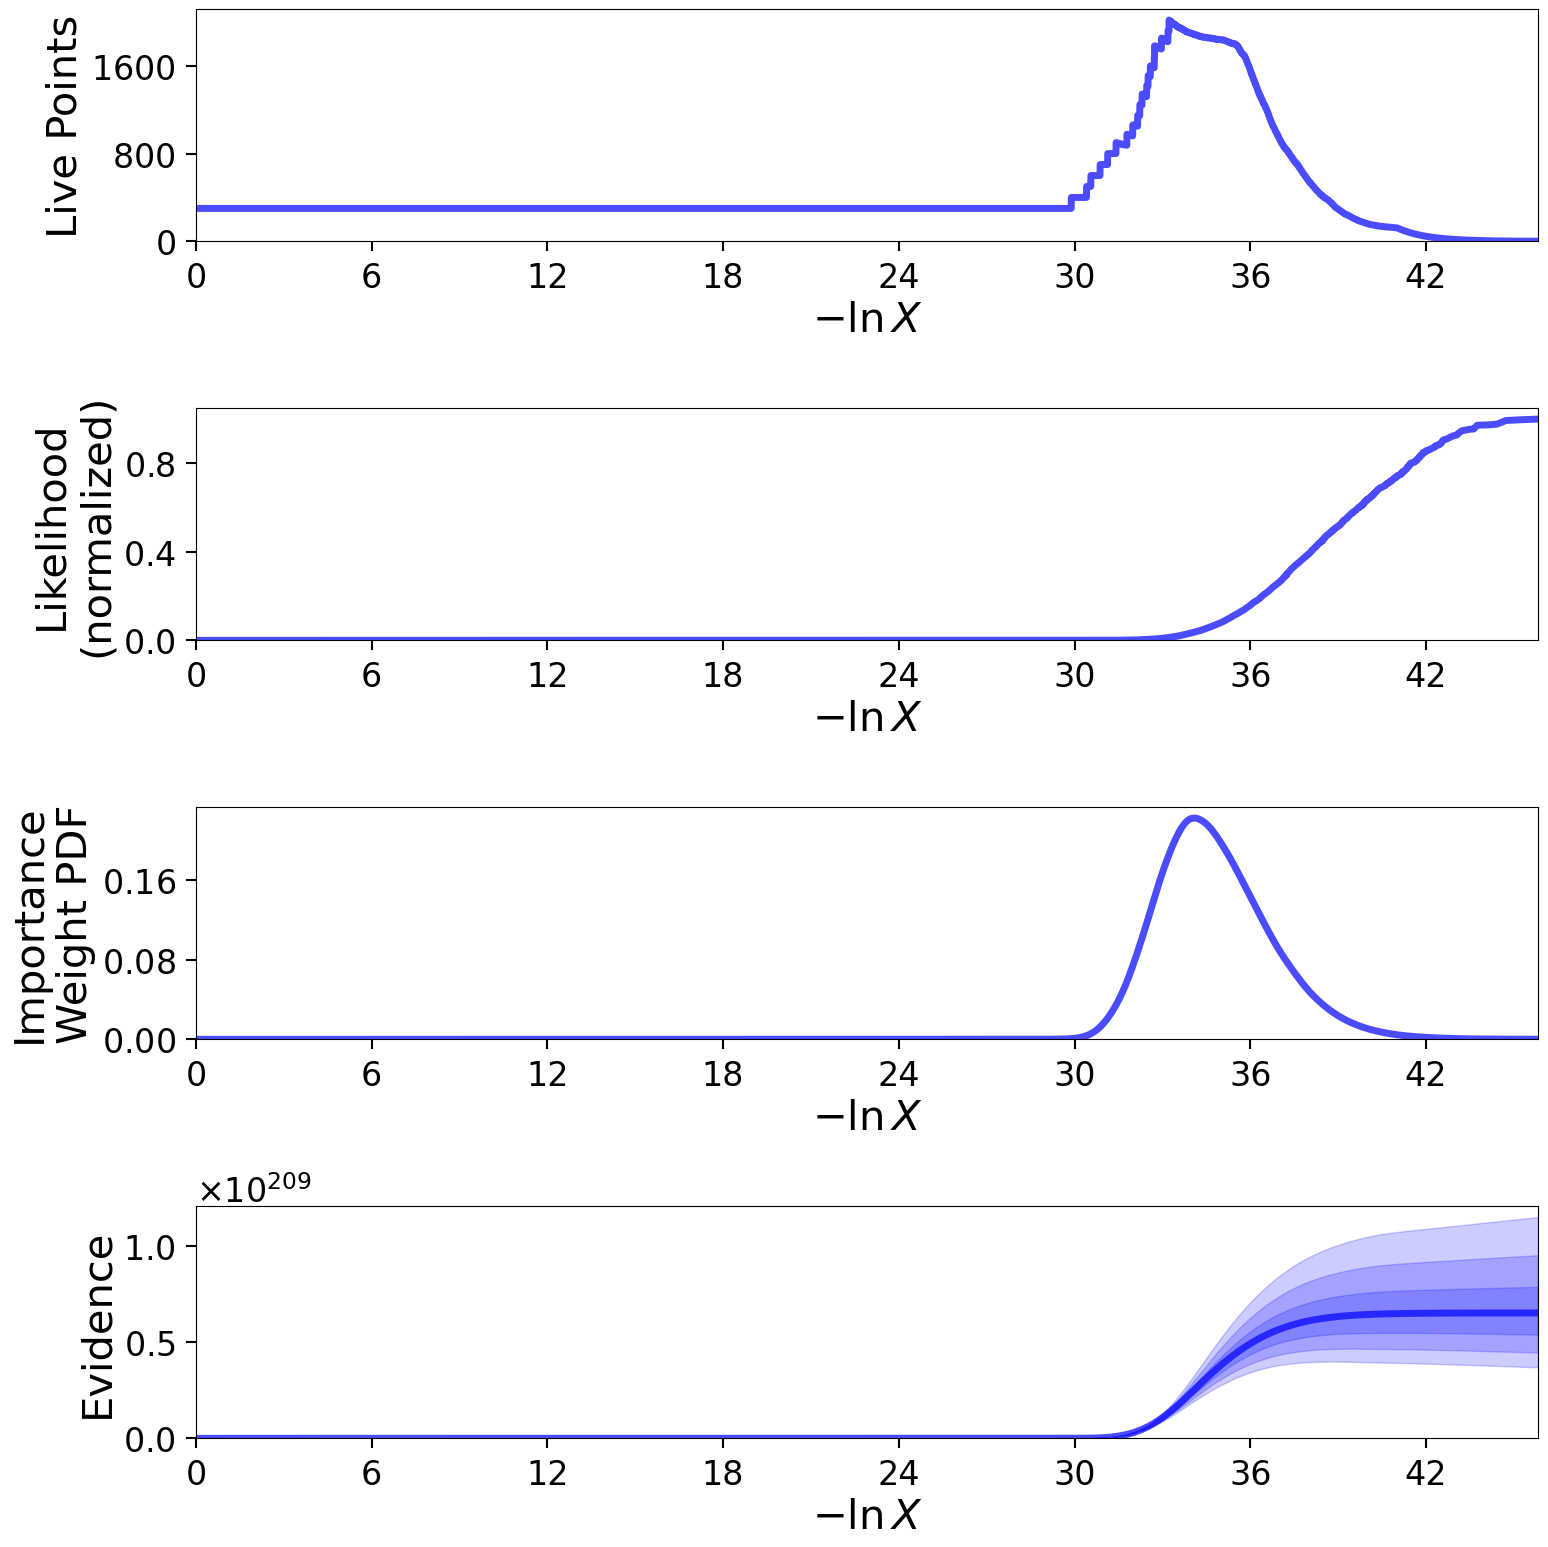

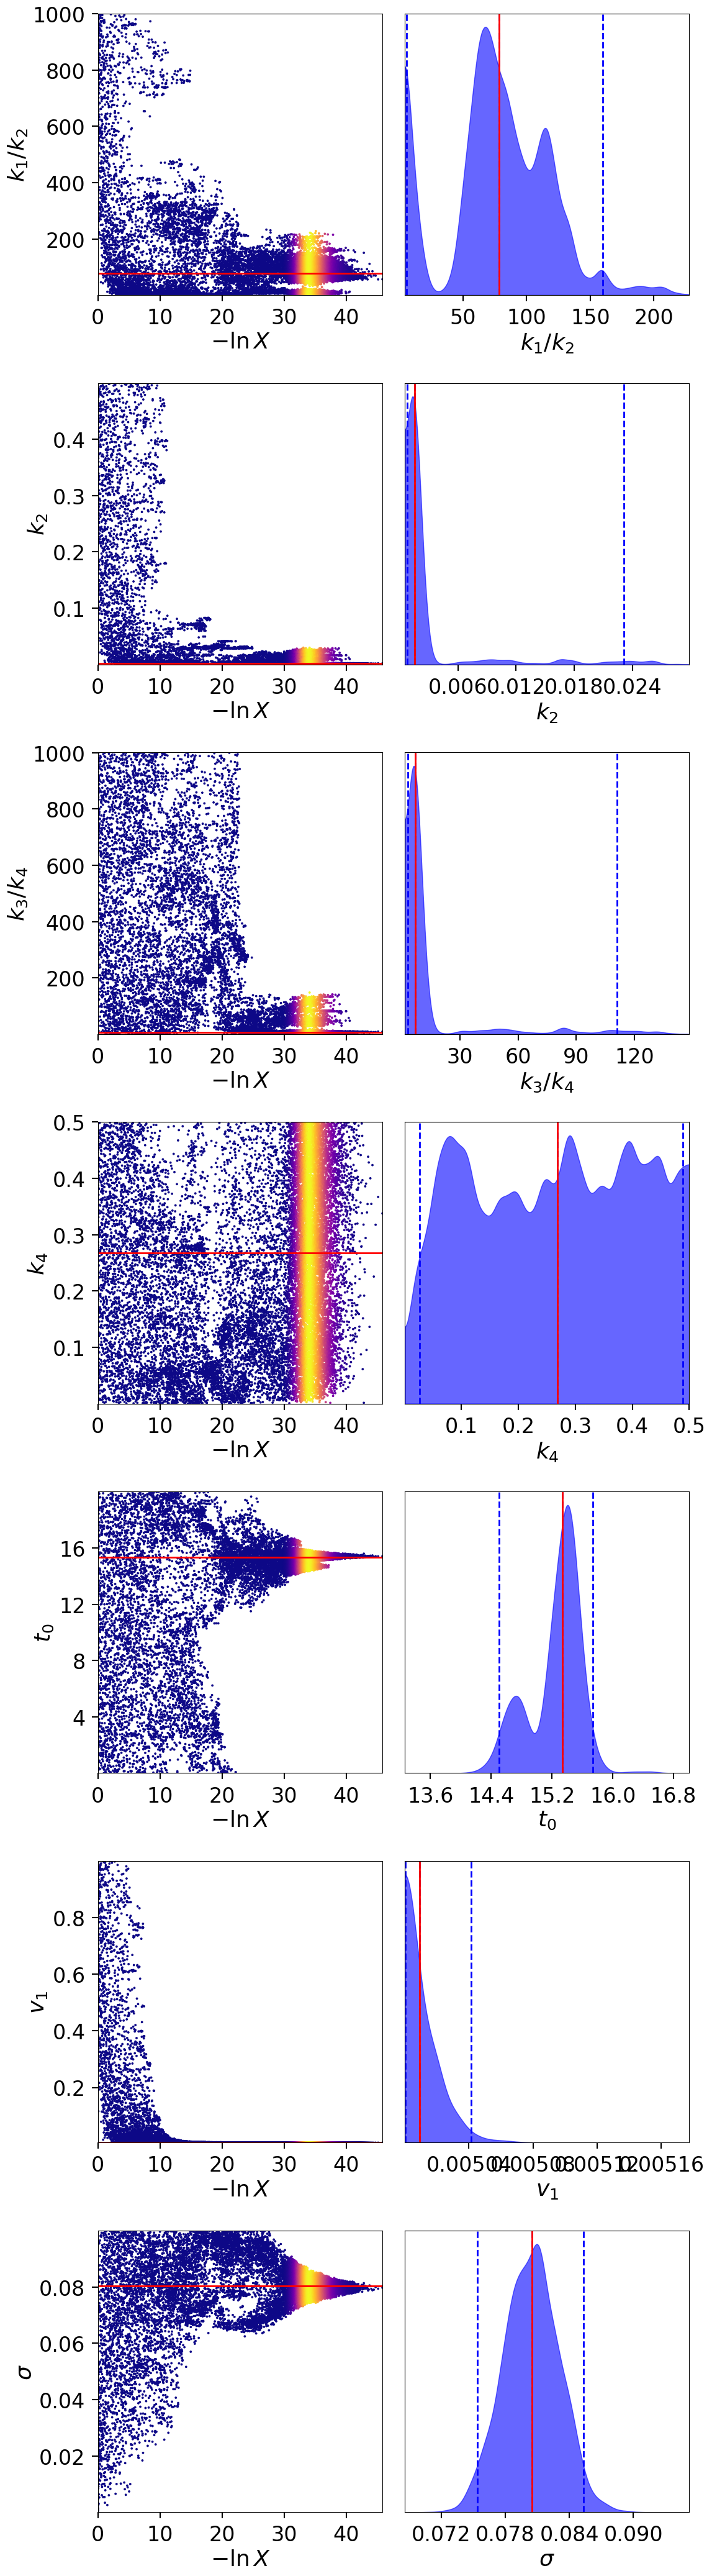

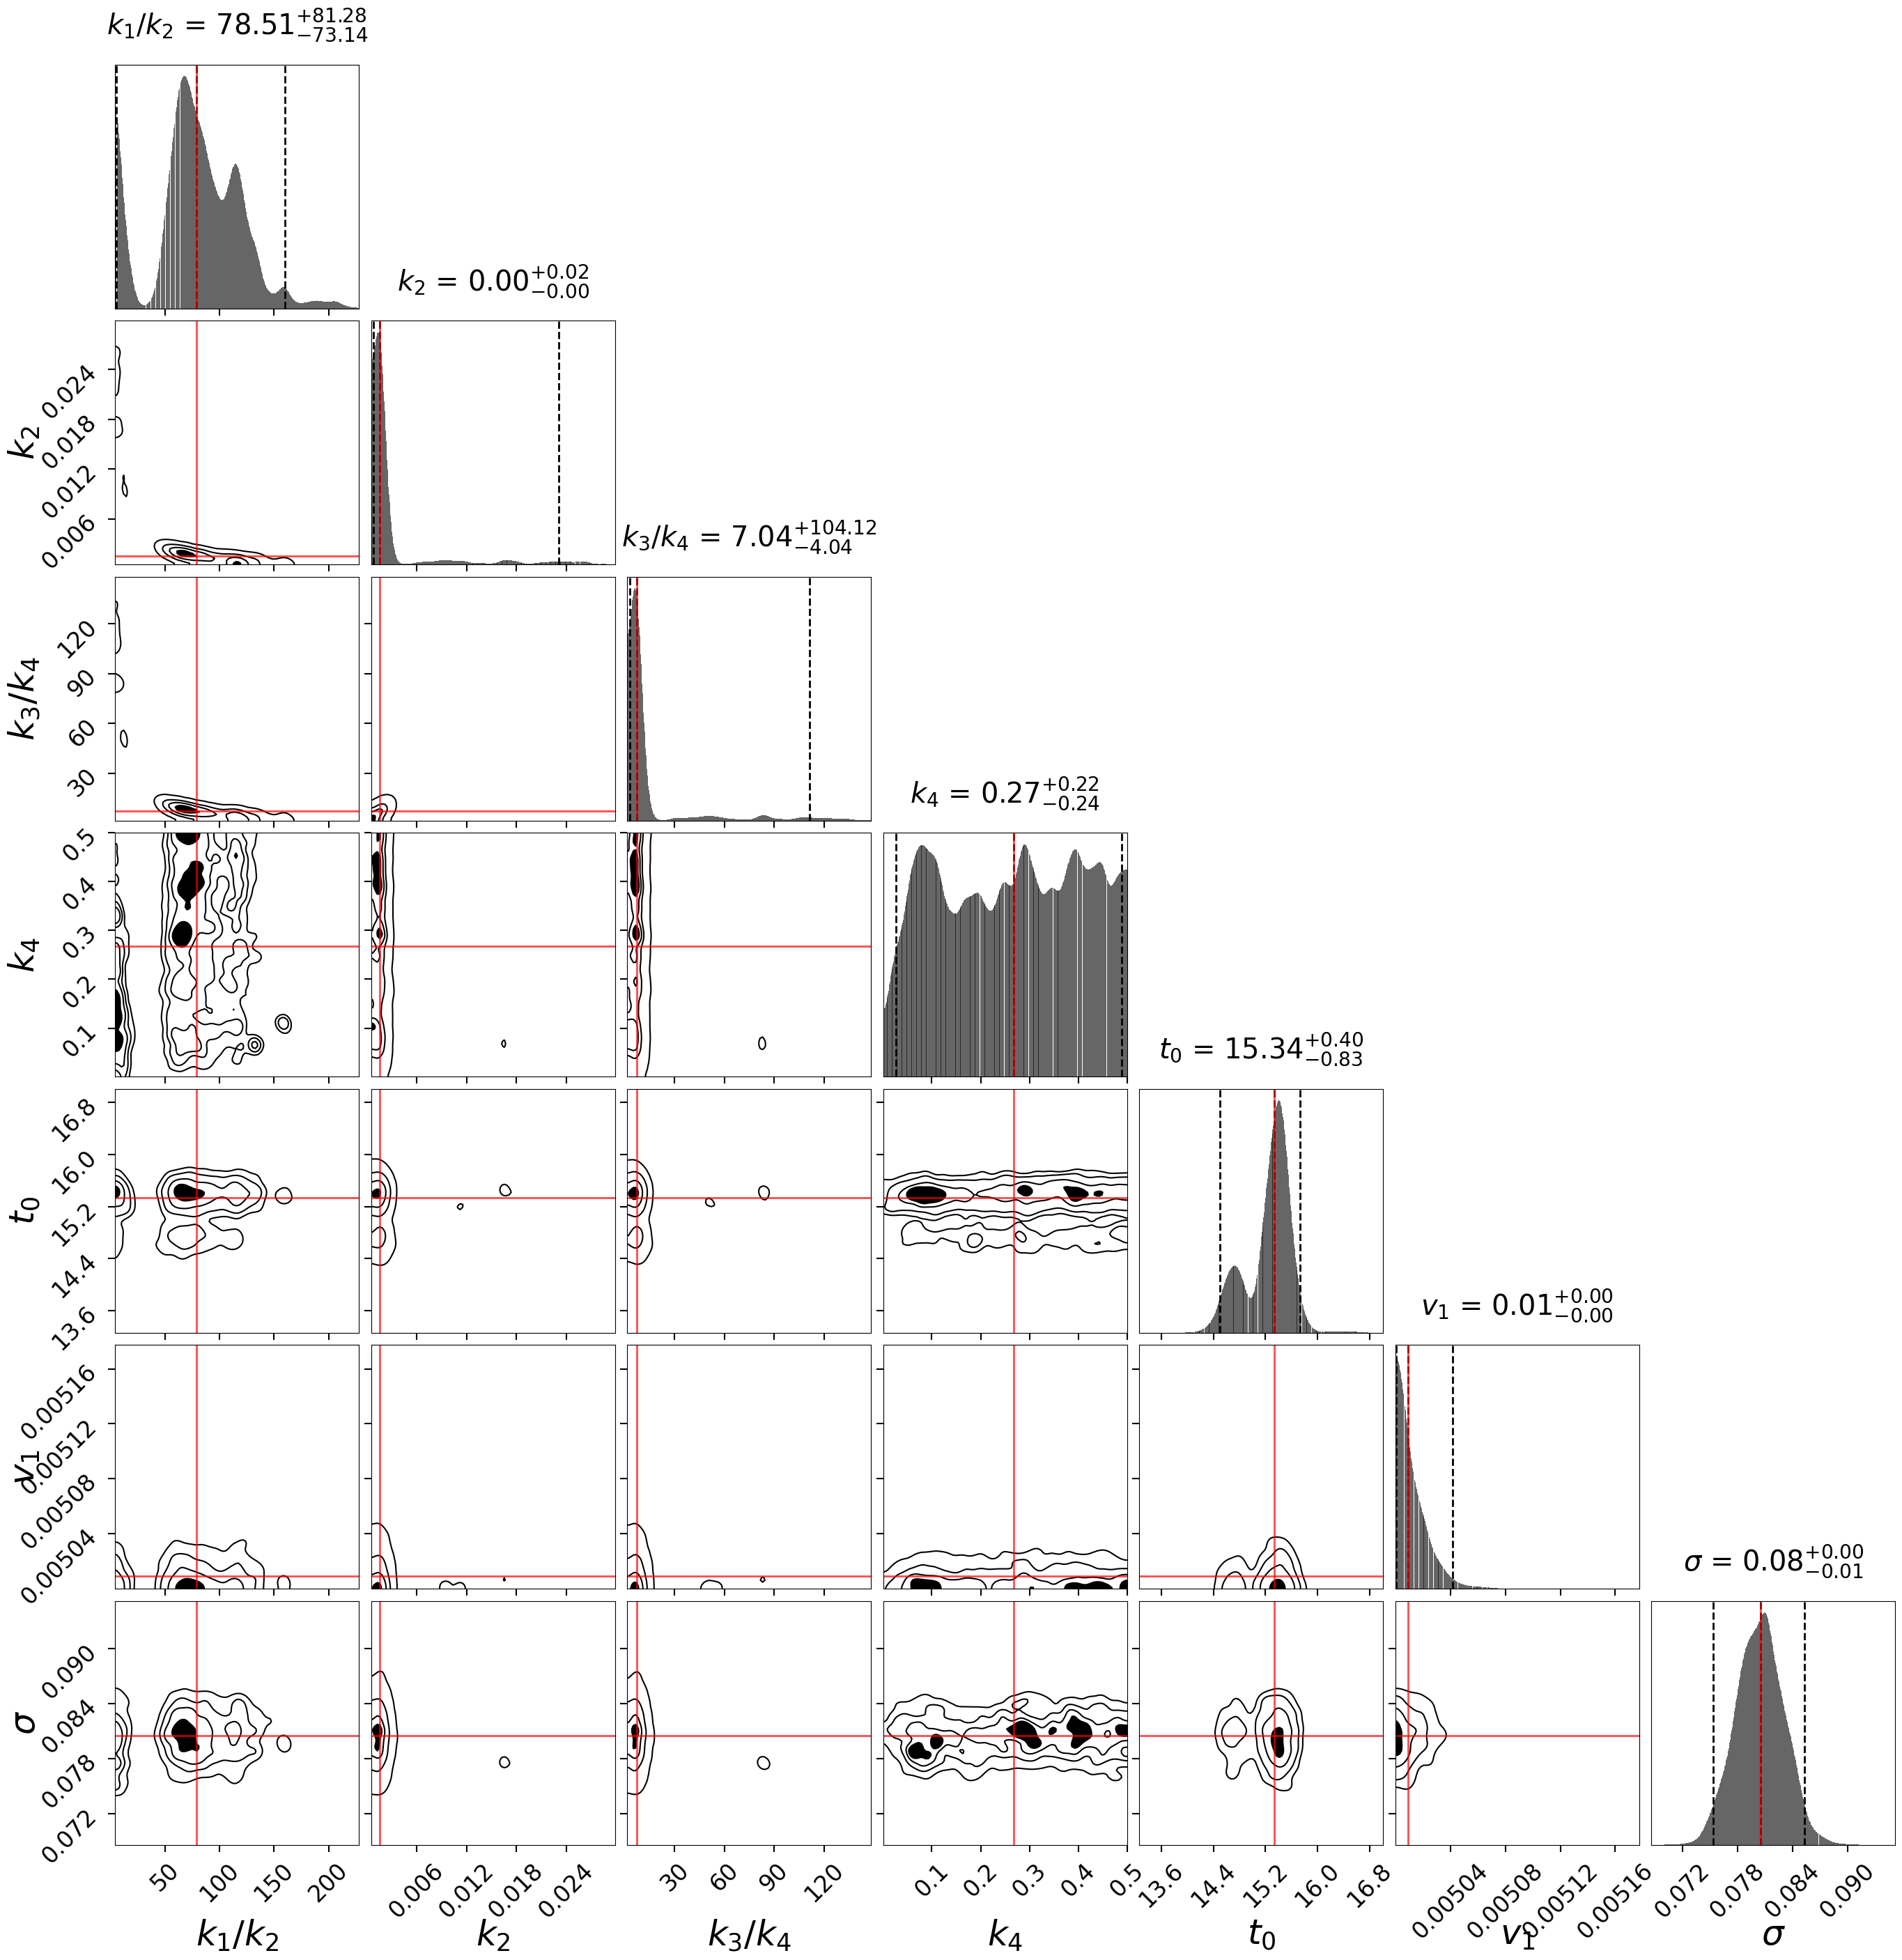

In [8]:
twotc_twil.plotting.results_plot(tag="playground_TwoTC_twil", parc_index=parc_index)

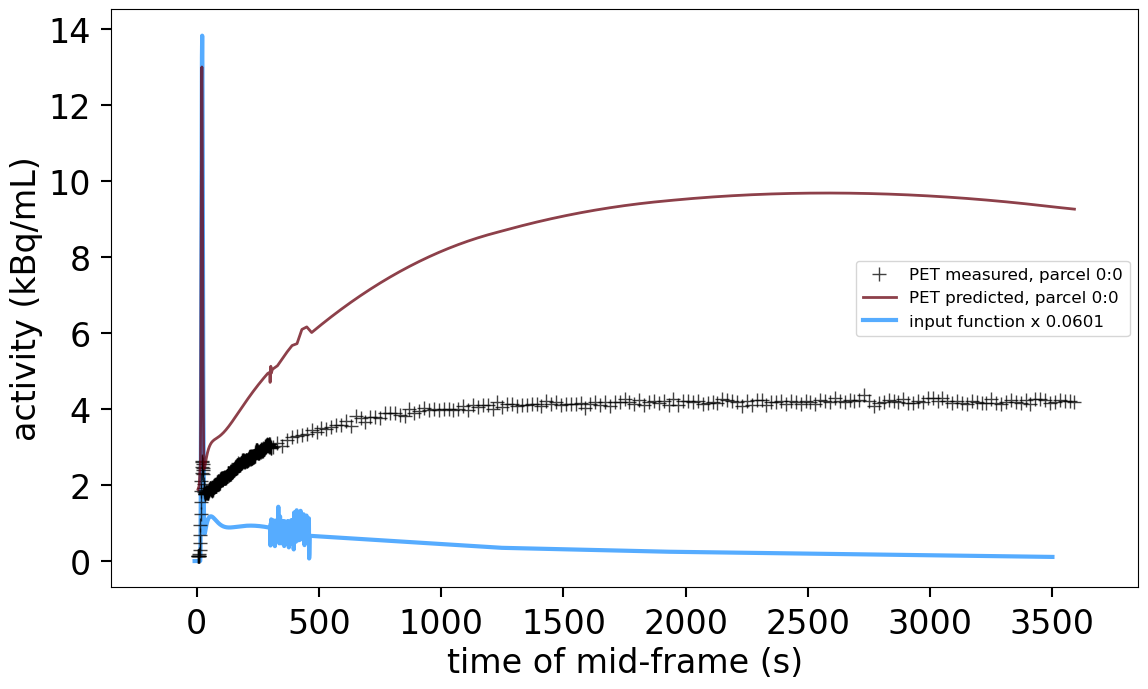

In [9]:
twotc_twil.plotting.parcs_plot()

## Inspect TwoTCContext idif

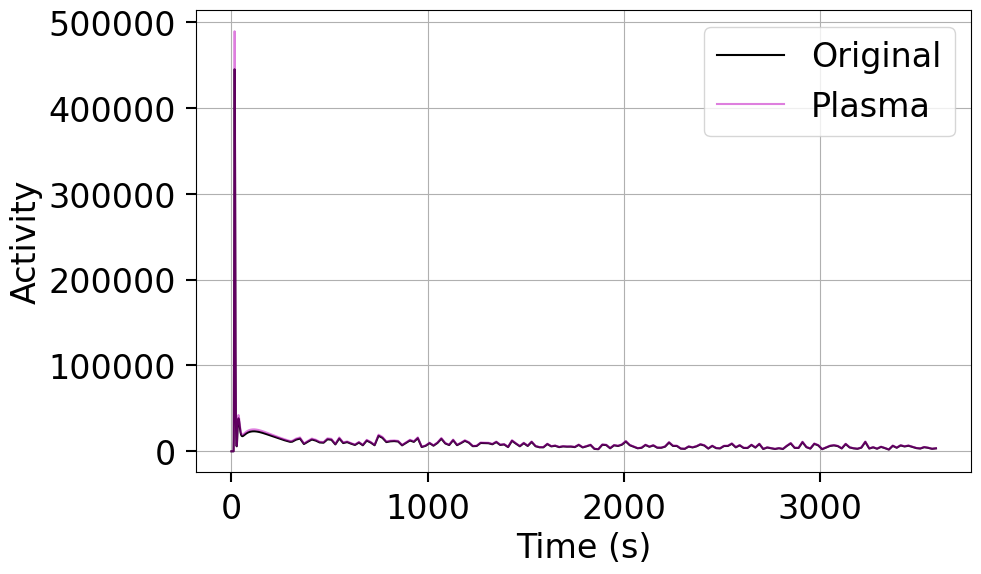

(465,)
'AUC: 18233441.47053301'


In [10]:
idif0 = BaseIO().nii_load(idif)
idif1 = rbcp.nii_wb2plasma(idif, output_format="niid")
idifp = rbcp.nii_wb2plasma(idif, output_format="fqfn")
plt.figure(figsize=(10,6))
plt.plot(idif0["timesMid"], 1.8509 * idif0["img"], 'k-', label='Original')
plt.plot(idif1["timesMid"], 1.8509 * idif1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

pprint(idif1["img"].shape)
auc = np.trapezoid(idif1["img"], idif1["timesMid"])
pprint(f"AUC: {auc}")

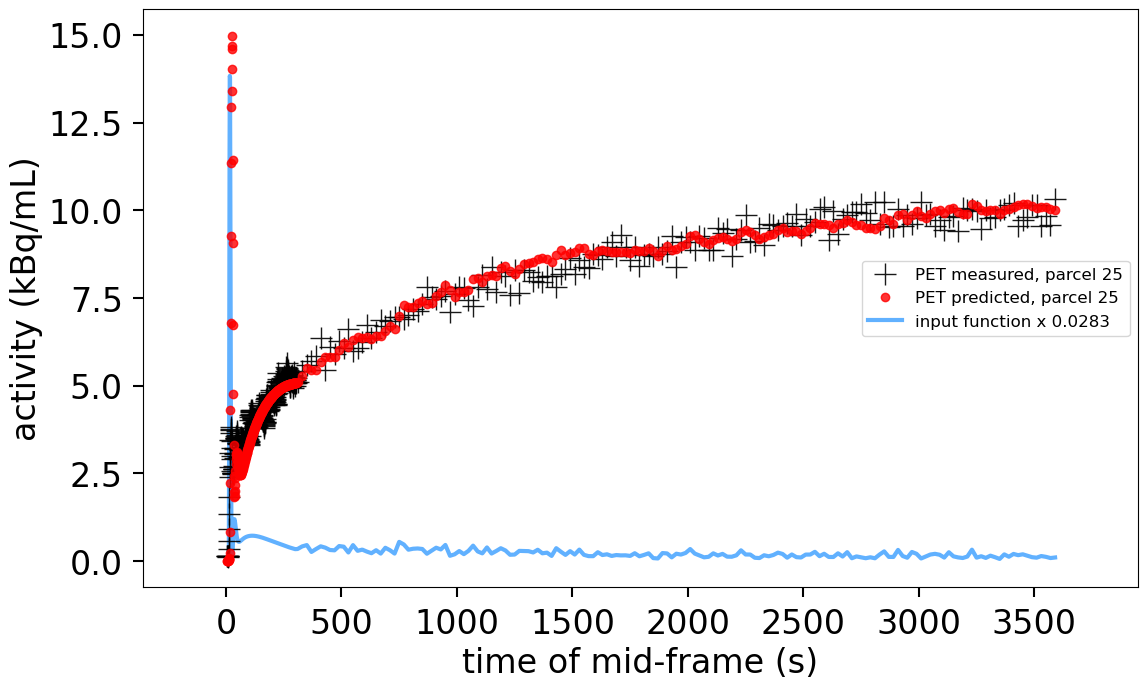

In [29]:
data_dict_idif = {
    "input_func_fqfn": idifp,
    "tissue_fqfn": pet,
    "v1_fqfn": v1_idif,
    "delta_time": 10,
    "nlive": 100,
    "tag": "playground_TwoTC_idif"
}
truth_twotc_idif = [
    9.93952947e+01, 1.70452960e-03, 4.35248142e+00, 3.00541926e-04,
       7.93600680e+00, 5.00539676e-03, 9.93197050e-02
]

twotc_idif = TwoTCContext(data_dict_idif)
twotc_idif.plotting.truths_plot(truths=truth_twotc_idif, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [12]:
res_idif = twotc_idif.solver.run_nested(print_progress=True, parc_index=parc_index)

17840it [04:41, 47.40it/s, batch: 17 | bound: 9 | nc: 59 | ncall: 1126135 | eff(%):  1.573 | loglstar: 350.819 < 347.360 <    inf | logz: 310.997 +/-  0.585 | stop:  1.905]                  /Users/jjlee/anaconda3/envs/dynesty12/lib/python3.12/site-packages/dynesty/sampling.py:420: UserWarning: The slice sample interval was expanded more than 1000 times
  warnings.warn('The slice sample interval was expanded more '
/Users/jjlee/anaconda3/envs/dynesty12/lib/python3.12/site-packages/dynesty/sampling.py:685: UserWarning: Enabling doubling strategy of slice sampling from Neal(2003)
  warnings.warn('Enabling doubling strategy of slice '
33296it [08:57, 61.95it/s, batch: 35 | bound: 57 | nc: 1 | ncall: 2394466 | eff(%):  1.386 | loglstar: 346.316 < 369.588 < 367.888 | logz: 319.826 +/-  0.240 | stop:  0.968]  


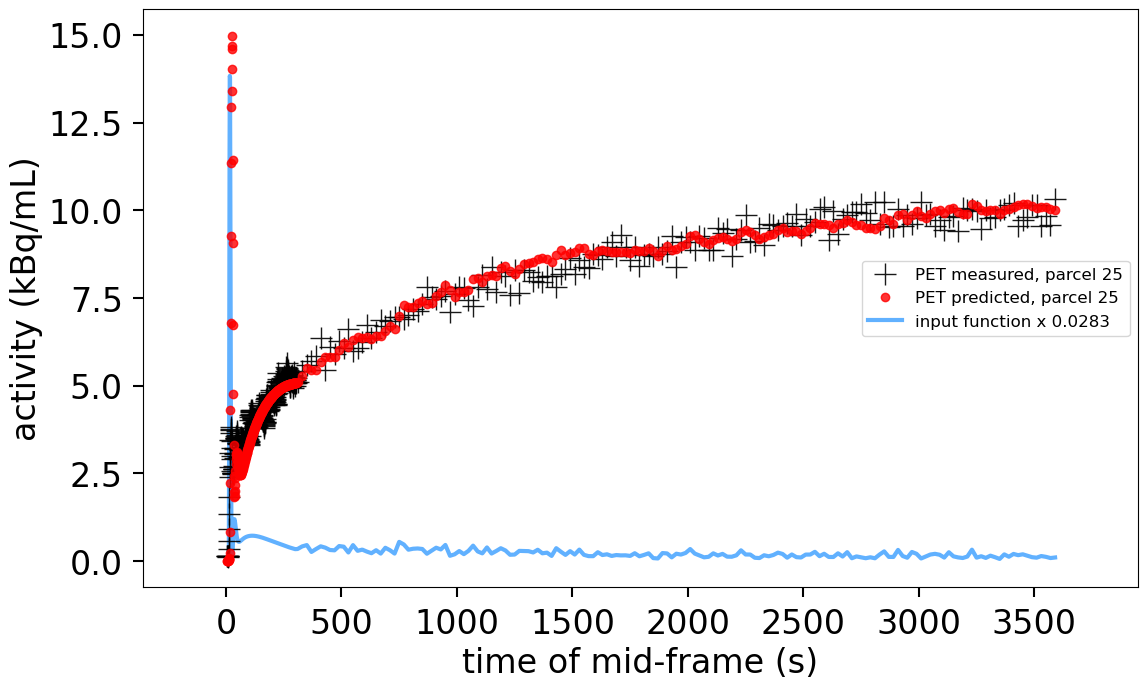

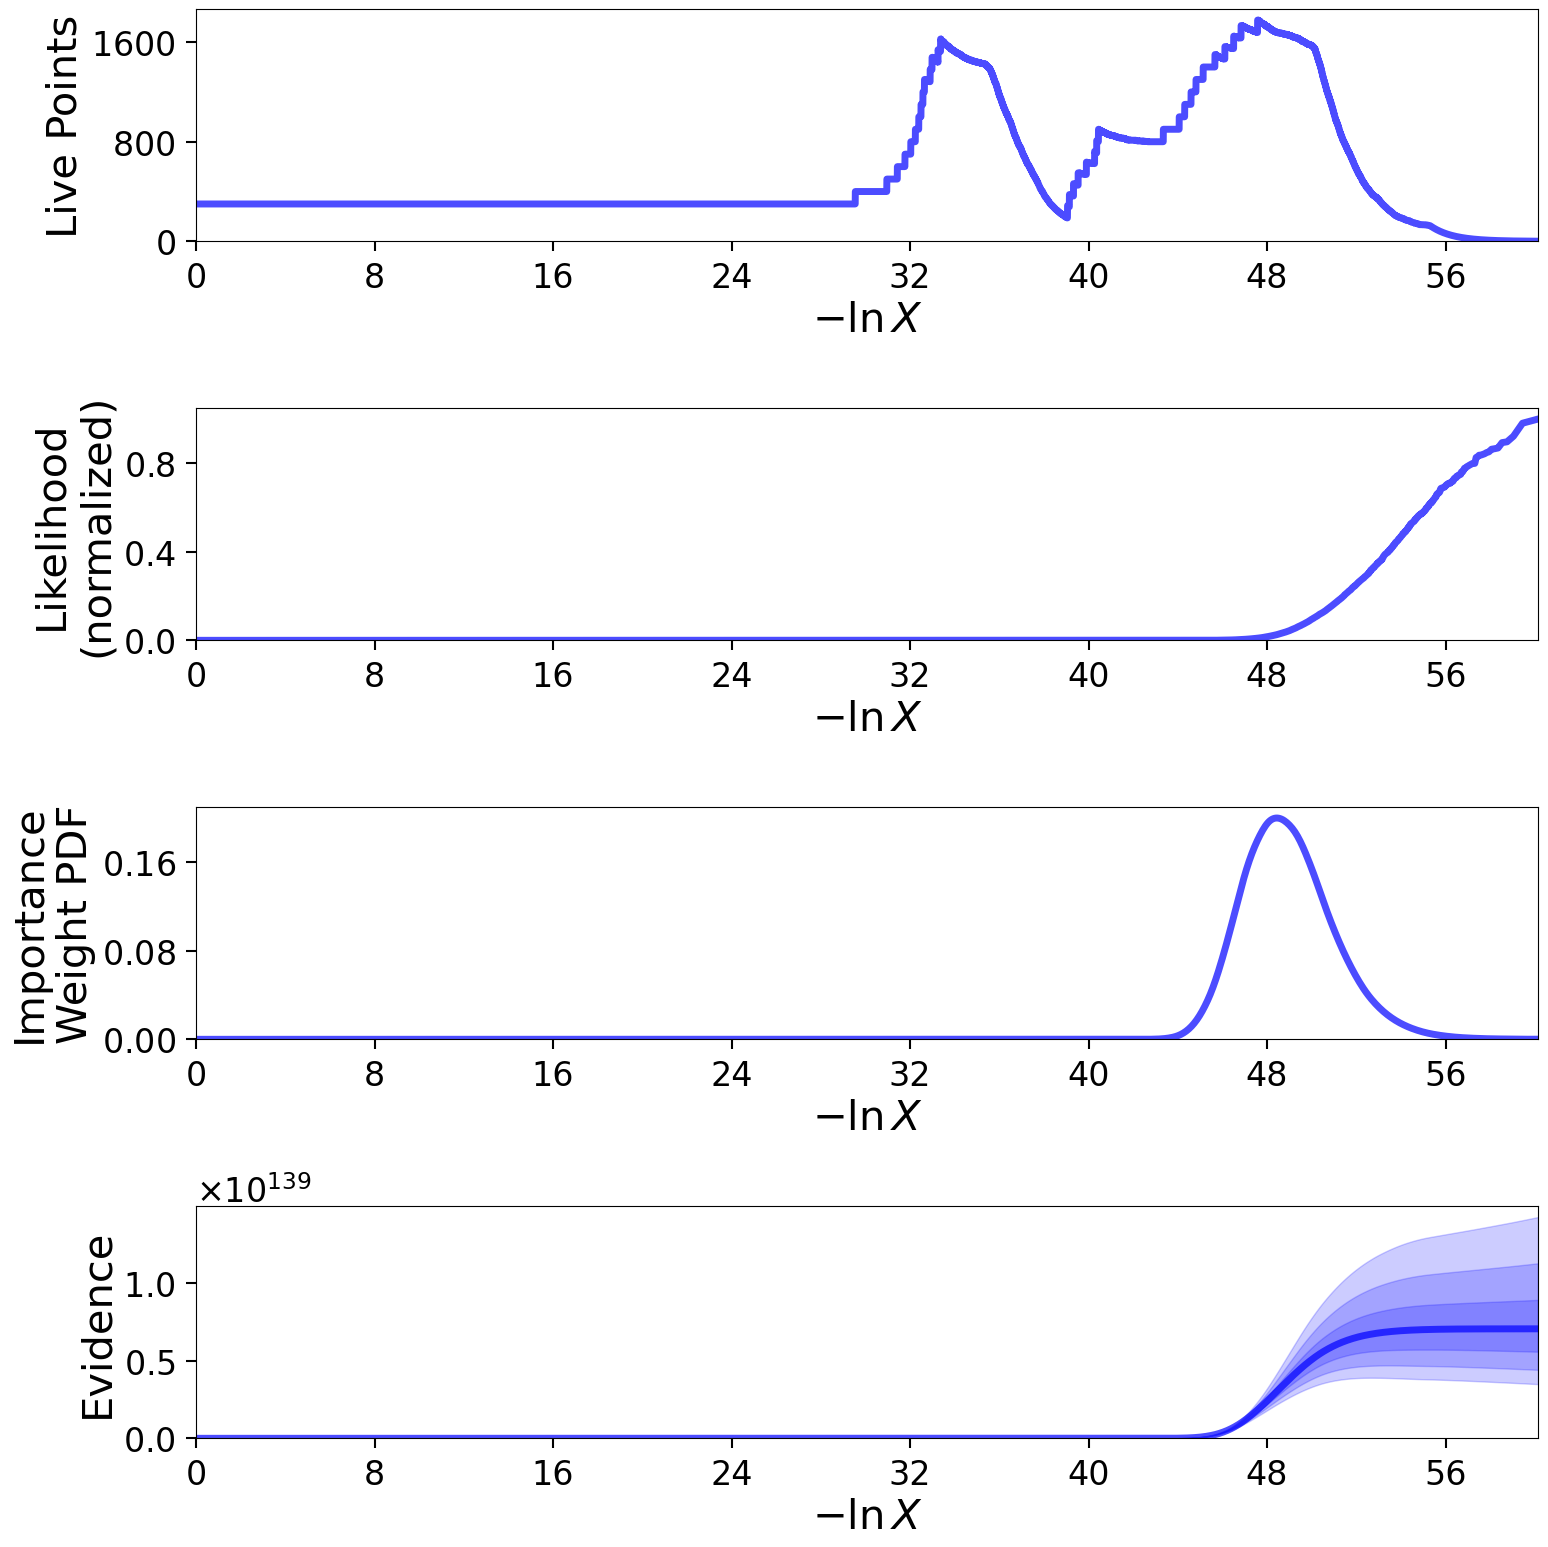

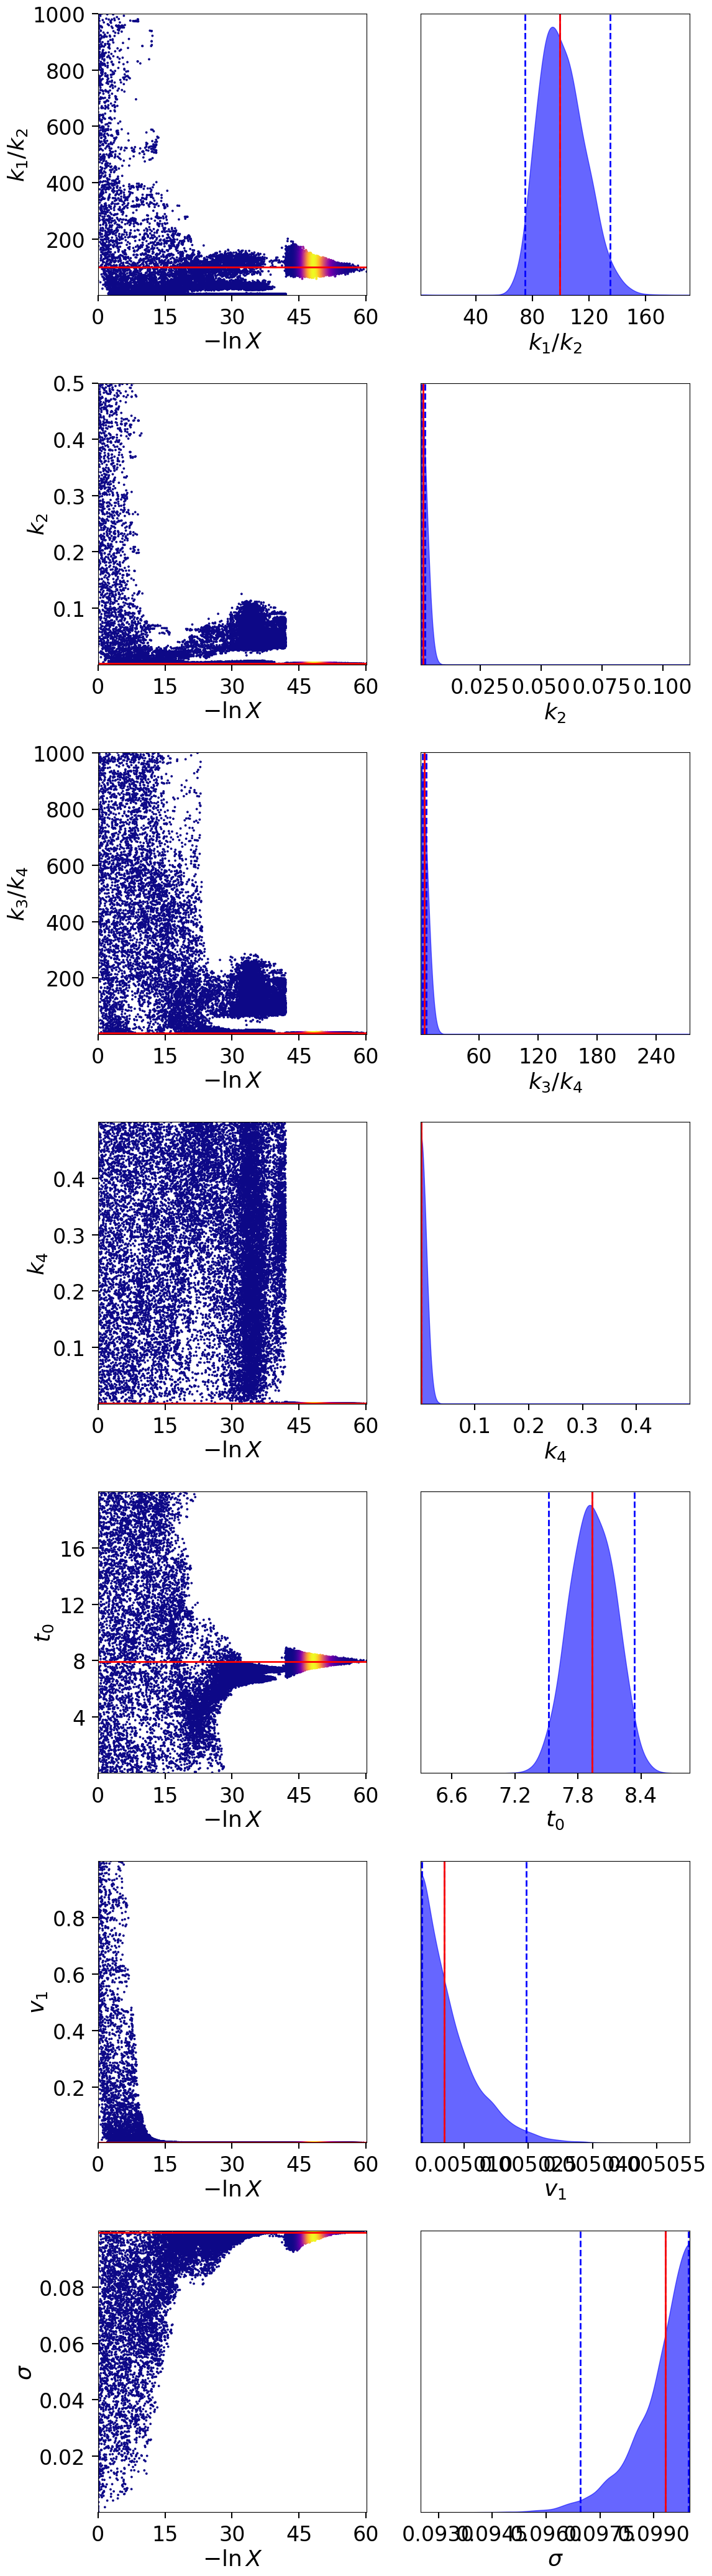

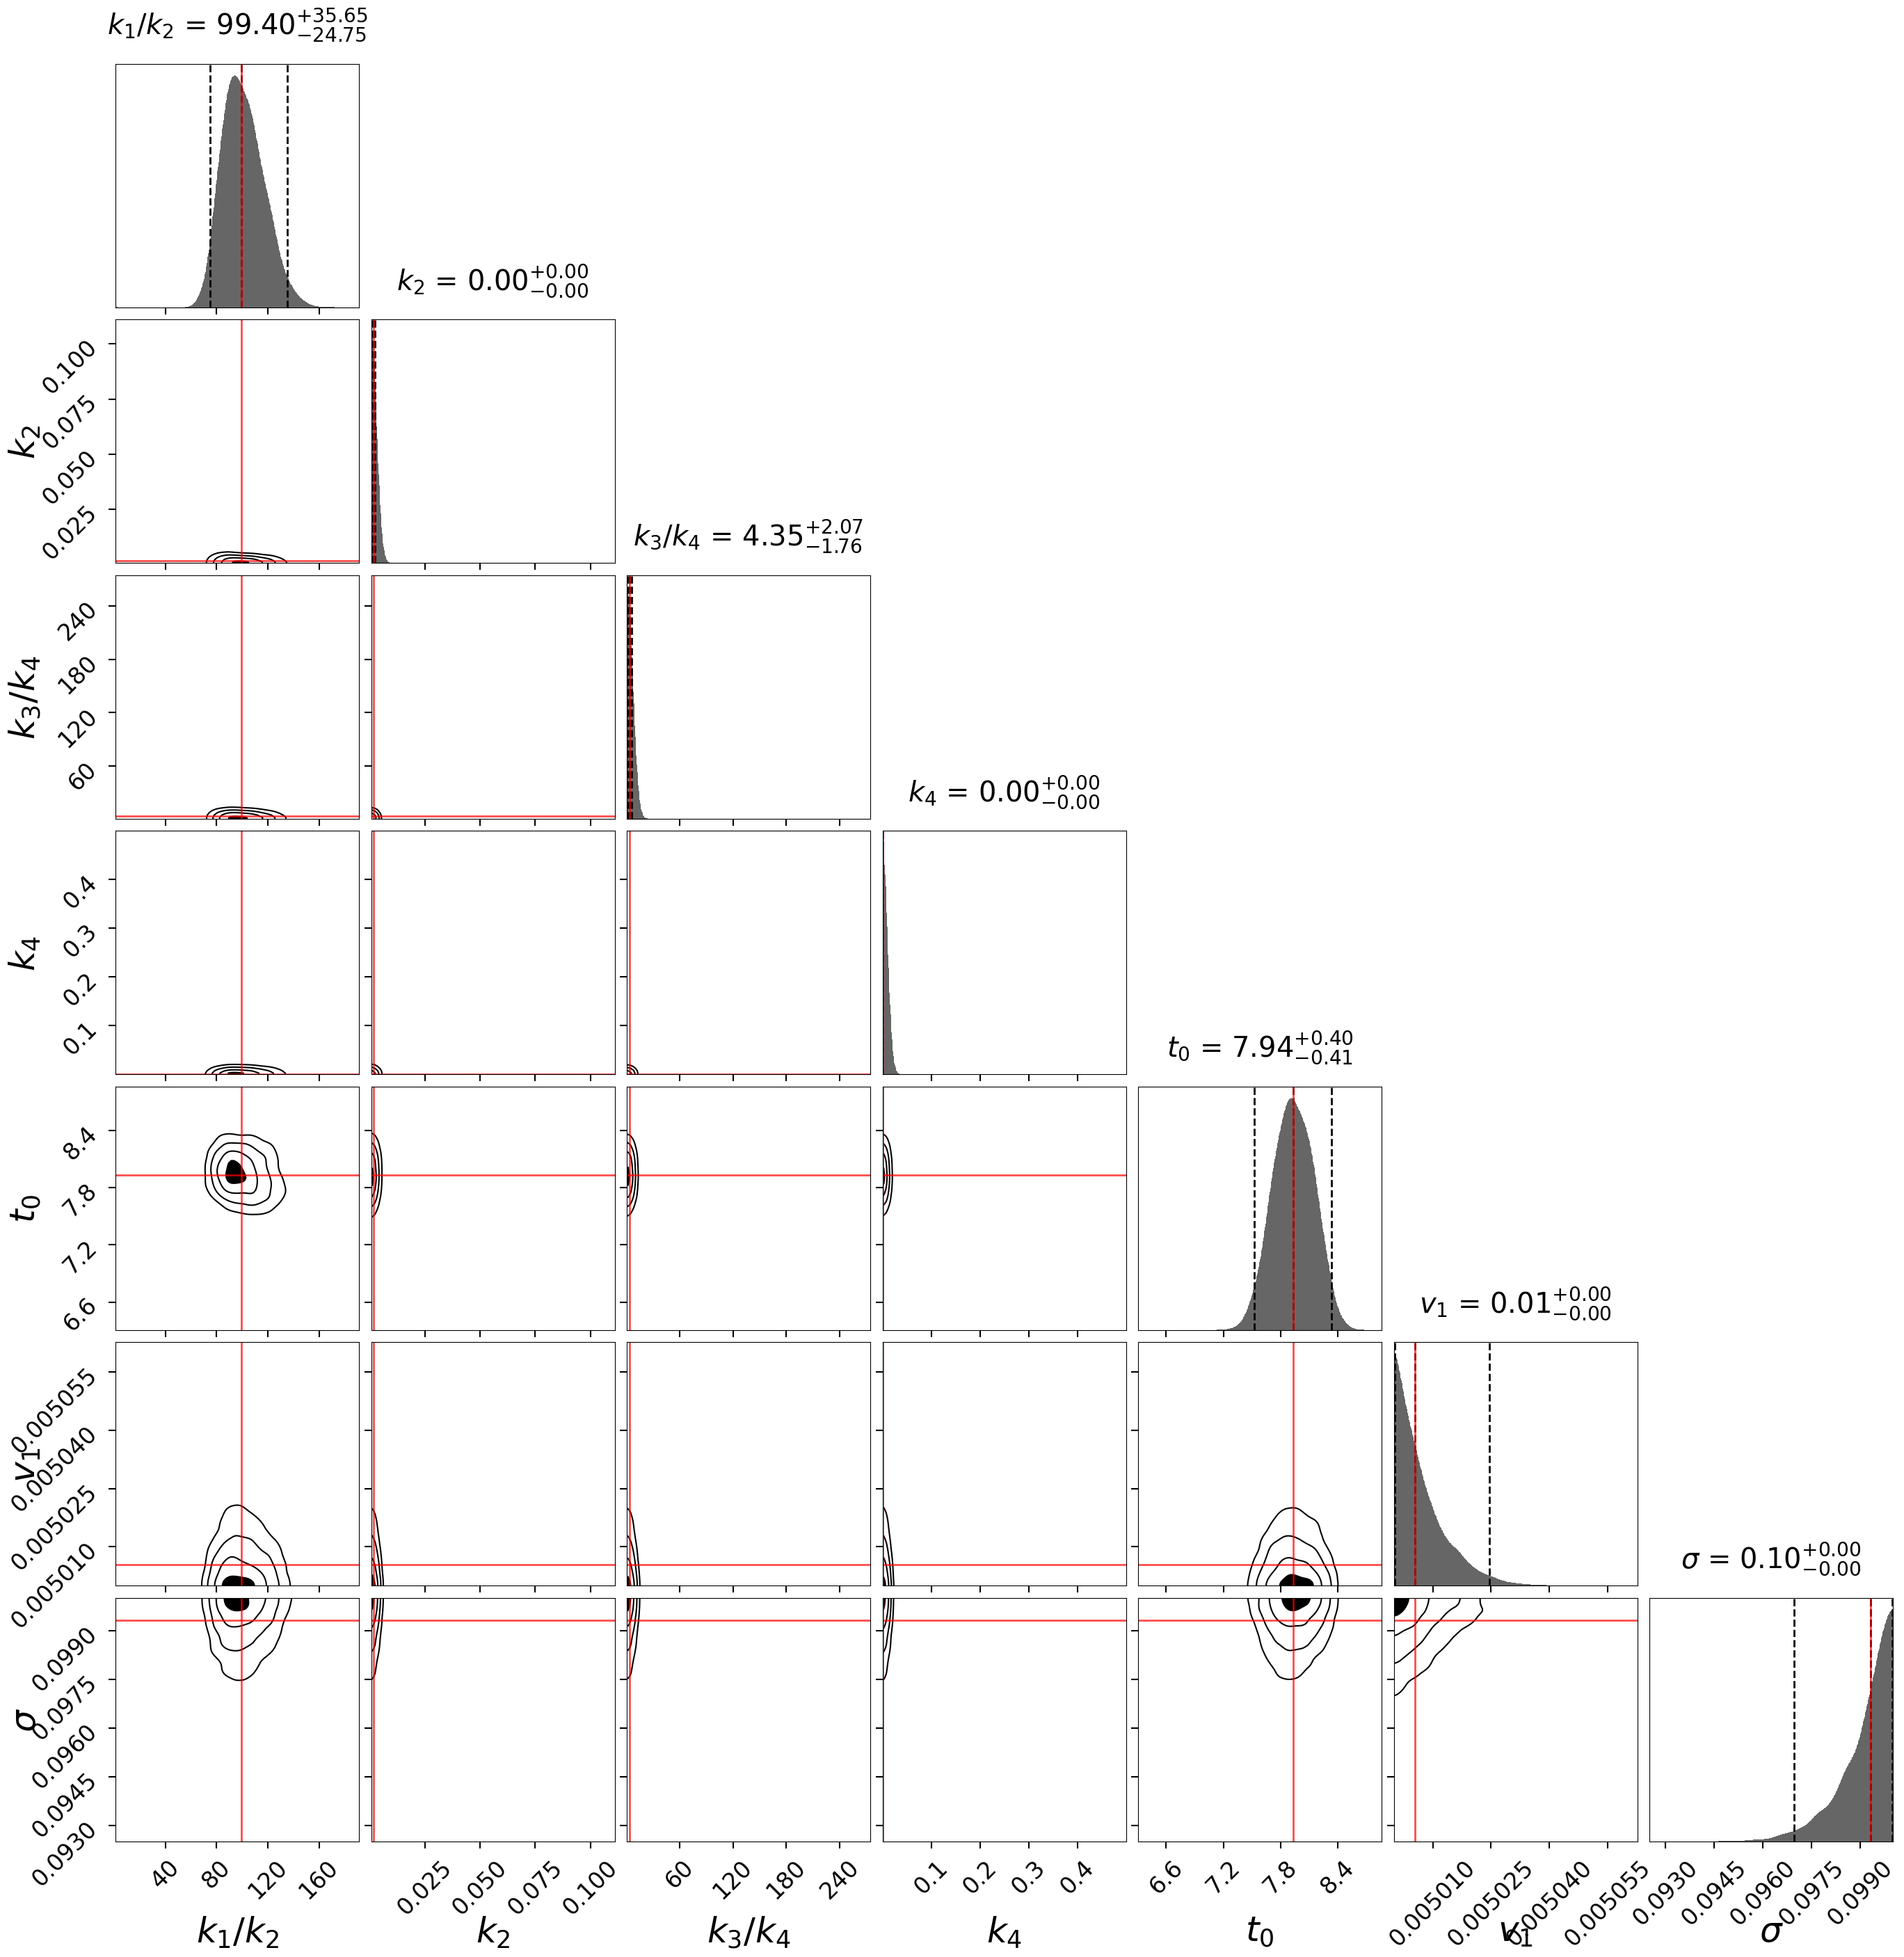

In [13]:
twotc_idif.plotting.results_plot(tag="playground_TwoTC_idif", parc_index=parc_index)

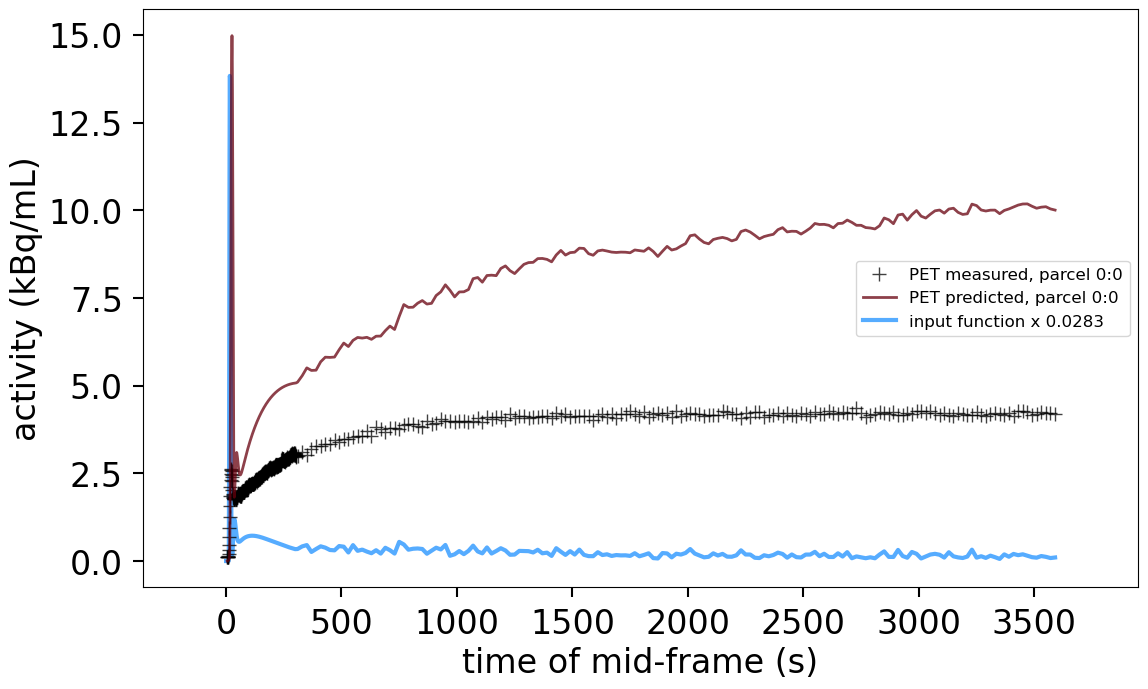

In [14]:
twotc_idif.plotting.parcs_plot()

In [15]:
twotc_twil.data.print_truths()
twotc_idif.data.print_truths()



=============================== Truths ===============================
Parameter                        Value
----------------------------------------
$k_1/k_2$                     78.50692
$k_2$                          0.00157
$k_3/k_4$                      7.04298
$k_4$                          0.26822
$t_0$                         15.33642
$v_1$                          0.00501
$\sigma$                       0.08048


=============================== Truths ===============================
Parameter                        Value
----------------------------------------
$k_1/k_2$                     99.39529
$k_2$                          0.00170
$k_3/k_4$                      4.35248
$k_4$                          0.00030
$t_0$                          7.93601
$v_1$                          0.00501
$\sigma$                       0.09932


In [16]:
pprint(twotc_twil.solver.truths)
pprint(twotc_idif.solver.truths)

array([7.85069218e+01, 1.57258831e-03, 7.04297733e+00, 2.68215357e-01,
       1.53364241e+01, 5.00917497e-03, 8.04790998e-02])
array([9.93952947e+01, 1.70452960e-03, 4.35248142e+00, 3.00541926e-04,
       7.93600680e+00, 5.00539676e-03, 9.93197050e-02])
